# Imports

In [1]:
from myAgent import CarlaAgent
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import glob
import os
import sys
import cv2
import math

try:
    sys.path.append(glob.glob('./carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla

## Initialize Simulation

In [3]:
myAgent = CarlaAgent()

myAgent.world = myAgent.client.load_world("Town04")
myAgent.map = myAgent.world.get_map()

RuntimeError: time-out of 4000ms while waiting for the simulator, make sure the simulator is ready and connected to localhost:2000

In [4]:
spawn_location = carla.Transform(carla.Location(x=68.331055, y=13.360283, z=11.057558), carla.Rotation(pitch=0.178746, yaw=-179.767502, roll=-0.007507))

myAgent.spawn_vehicle(transform=spawn_location)

myAgent.attach_camera()
myAgent.attach_cameraS()
myAgent.attach_controller()

print("deployed")
myAgent.spectator = myAgent.world.get_spectator()
myAgent.find_vehicle()

created vehicle.tesla.model3
created sensor.camera.rgb
created sensor.camera.semantic_segmentation
deployed


## Waypoints

In [91]:
myAgent.map = myAgent.world.get_map()
waypoints = myAgent.map.generate_waypoints(10)

x = []
y = []

for waypoint in waypoints:
    x.append(waypoint.transform.location.x)
    y.append(waypoint.transform.location.y)
    
plt.scatter(x,y)

print(dir(waypoints[0]))
a = waypoints[100].get_right_lane()
print(a)

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


## Lane Ground Truth

In [102]:
def lane_GT(myAgent):
    my_location = myAgent.vehicle.get_location()
    closest_waypoint = myAgent.map.get_waypoint(my_location)
    right_lane = closest_waypoint.get_right_lane()
    left_lane = closest_waypoint.get_left_lane()
    distance_to_right_lane = 0
    distance_to_left_lane = 0
    array = np.zeros((4, 1))
    
    if right_lane is not None:
        distance_to_right_lane = np.sqrt((my_location.x - right_lane.transform.location.x)**2 + (my_location.y - right_lane.transform.location.y)**2)
        array[0] = right_lane.transform.location.x
        array[1] = right_lane.transform.location.y
    if left_lane is not None:
        distance_to_left_lane = np.sqrt((my_location.x - left_lane.transform.location.x)**2 + (my_location.y - left_lane.transform.location.y)**2)
        array[2] = left_lane.transform.location.x
        array[3] = left_lane.transform.location.y
    return array, distance_to_right_lane, distance_to_left_lane

print(lane_GT(myAgent))

(array([[68.23243713],
       [ 9.85985279],
       [68.20401001],
       [16.85979652]]), 3.501802201027567, 3.5018234735225127)


## Traffic light

In [98]:
def traffic_light_state(myAgent):
    return myAgent.vehicle.get_traffic_light_state()

print(traffic_light_state(myAgent))

Green


## Bounding boxes

In [44]:
bbs = myAgent.world.get_level_bbs()
print(bbs[0])

BoundingBox(Location(x=-534.104187, y=97.756577, z=0.227508), Extent(x=1.241211, y=1.169299, z=1.472754), Rotation(pitch=10.036157, yaw=139.847183, roll=-20.327358))


## Controller


In [105]:
class Controller:
    # Velocity controller parameters
    target_velocity = 0
    kp_vel = 0.08
    ki_vel = 0.02
    kd_vel = 0.001

    vel_error_0 = 0
    I_vel_error = 0
    D_vel_error = 0

    # Lateral controller parameters
    kp_lat = 0.08
    ki_lat = 0.02
    kd_lat = 0.001

    deviation_0 = 0
    I_deviation = 0
    D_deviation = 0

    def set_target_velocity(self, velocity):
        self.target_velocity = velocity
        self.D_vel_error = 0
        self.vel_error_0 = 0
        self.I_vel_error = 0

    def velocity_controller(self, dt, current_velocity):
        throttle = 0
        brake = 0
        if dt == 0:
            dt = 1e-3

        vel_error = self.target_velocity - current_velocity  # velocity error
        self.D_vel_error = (vel_error - self.vel_error_0) / dt  # velocity error difference
        self.I_vel_error = self.I_vel_error + vel_error * dt  # velocity error integral over time
        self.vel_error_0 = vel_error

        throttle_signal = self.kp_vel * vel_error + self.ki_vel * self.I_vel_error + self.kd_vel * self.D_vel_error

        if throttle_signal > 1:
            throttle = 1
        elif throttle_signal > 0:
            throttle = throttle_signal
        elif throttle_signal > -1:
            brake = abs(throttle)
        else:
            brake = 1

        return throttle, brake

    def lateral_controller(self, dt, deviation):
        if dt == 0:
            dt = 1e-3

        self.D_deviation = (self.deviation_0 - deviation) / dt
        self.I_deviation = self.I_deviation + deviation * dt
        self.deviation_0 = deviation

        steering = self.kp_lat * deviation + self.ki_lat * self.I_deviation + self.kd_lat * self.D_deviation
        steering = max(min(steering, 1), -1)
        return steering


## Lane keeping routine

In [106]:
sim_time = 200 # in seconds
autopilot = True

controller = Controller()
controller.set_target_velocity(20)

speed_history = []
throttle_history = []
brake_history = []
steering_history = []

traffic_history = []

left_lane_x = []
left_lane_y = []
left_lane_dist = []
right_lane_x = []
right_lane_y = []
right_lane_dist = []

myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 0

myAgent.vehicle.apply_control(myAgent.control)

myAgent.vehicle.set_autopilot(autopilot)

t0 = time.time()
t1 = t0
simulation_start_time = t0
observer_last_updated = t0 

while(t1 - simulation_start_time < sim_time):
    t1 = time.time()
    dt = t1 - t0 # discrete time step del_t
    t0 = t1
    
    if (t1 - observer_last_updated > 2): # update observer each 2 seconds
        observer_last_updated = t1
        myAgent.find_vehicle()
        
        
    # Get images and segmentation results    
    lane_class = 6
    road_class = 7
    
    RGB_image = np.copy(myAgent.image)
    
    segmentation_lane = np.copy(myAgent.imageS[:,:,2])
    segmentation_lane[segmentation_lane!=lane_class] = 0
    segmentation_lane[segmentation_lane==lane_class] = 255
    
    segmentation_road = np.copy(myAgent.imageS[:,:,2])
    segmentation_road[segmentation_road!=road_class] = 0
    segmentation_road[segmentation_road==road_class] = 255
    
    # Get lane and traffic information
    
    array, dist_right, dist_left = lane_GT(myAgent)
    right_lane_x.append(array[0])
    right_lane_y.append(array[1])
    right_lane_dist.append(dist_right)
    left_lane_x.append(array[2])
    left_lane_y.append(array[3])
    left_lane_dist.append(dist_left)
    
    traffic_state = traffic_light_state(myAgent)
    if (traffic_state == 'Green'):
        traffic_history.append(1)
    else:
        traffic_history.append(0)
    
    # process segmentation image for road and lanes and find deviation
    # RGB_image, lane_deviation = lane_tracker(RGB_image, segmentation_road, segmentation_lane)
    
    # feed velocity to controller
    velocity = myAgent.vehicle.get_velocity()
    velocity_kmh = (3.6 * math.sqrt(velocity.x**2 + velocity.y**2 + velocity.z**2))
    speed_history.append(velocity_kmh)
    
    
    if autopilot == False:
        
        myAgent.control.throttle, myAgent.control.brake = controller.velocity_controller(dt, velocity_kmh)
        # myAgent.control.steer = controller.lateral_controller(dt, lane_deviation)
        myAgent.vehicle.apply_control(myAgent.control)
        
        throttle_history.append(myAgent.control.throttle)
        brake_history.append(myAgent.control.brake)
        # steering_history.append(myAgent.control.steer)
        
        
    # plot results
    hough = cv2.HoughLinesP(segmentation_lane, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)
    lineslines = cv2.cvtColor(segmentation_lane, cv2.COLOR_GRAY2BGR)
    try:
        for line in hough:
            x1, y1, x2, y2 = line.reshape(4)
            lineslines = cv2.line( lineslines, (x1, y1), (x2, y2), (255, 0, 0), 5)
    except:
        print("No lines")
        
    cv2.imshow('camera feed', RGB_image)
    # cv2.imshow('road segmentation', cv2.cvtColor(segmentation_road, cv2.COLOR_GRAY2BGR))
    cv2.imshow('detected lanes', lineslines)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
        
cv2.destroyAllWindows()
        
myAgent.vehicle.set_autopilot(False)
myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0
myAgent.vehicle.apply_control(myAgent.control)
myAgent.find_vehicle()


No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines
No lines


<function matplotlib.pyplot.show(close=None, block=None)>

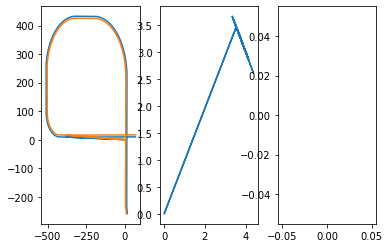

In [108]:
plt.subplot(131)
plt.plot(right_lane_x, right_lane_y, left_lane_x, left_lane_y)
plt.subplot(132)
plt.plot(right_lane_dist, left_lane_dist)
plt.subplot(133)
plt.plot(brake_history)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

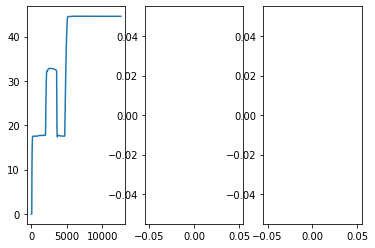

In [107]:
plt.subplot(131)
plt.plot(speed_history)
plt.subplot(132)
plt.plot(throttle_history)
plt.subplot(133)
plt.plot(brake_history)
plt.show

## Reverse Gear

In [9]:
myAgent.control.throttle = 1
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 0
myAgent.control.reverse = 1

myAgent.vehicle.apply_control(myAgent.control)


t = time.time()
while(time.time()-t < 1):
    None
    
myAgent.control.throttle = 0
myAgent.control.brake = 0
myAgent.control.steer = 0
myAgent.control.hand_brake = 1
myAgent.control.reverse = 0

myAgent.vehicle.apply_control(myAgent.control)

## Terminate Simulation

In [20]:
myAgent.terminate()

destroying actors
terminated
